<a href="https://colab.research.google.com/github/annafumagalli/LISA-M-project/blob/master/CDAE_timeseries_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install torch

In [0]:
%matplotlib inline
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt

#from torchsummary import summary
import torch
from torch import nn, optim
from torch.autograd import Variable
import time
from time import strftime, localtime
import copy
import random

In [3]:
torch.cuda.get_device_name(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Datasets

Set 1: mixture of randomly generated sines and sine-gaussians within sensible parameters ranges and NO noise.

## Training

- 100 mixed signals + clean/target sources signals

In [0]:
# Parameters

n = 1000 # number of training/testing datasets 

T = 180     # 3 min of data, sampled every 0.1 s
fs = 10
N = T*fs
t = np.linspace(0,T,N)

# These vary..

# frequency of sine wave
freq_sin = np.random.uniform(0.0, 1.0, n)
# phase of sine wave
phase_shift_sin = np.random.uniform(0.0, 2.0*np.pi, n)
# pulse starting time of sine gaussian
t0_sg = np.random.uniform(0.0, T, n)                  

# These are fixed

#amplitude, phase, frequency and tau of sine gaussian
a = 0.1             
phi0 = np.pi
f0 = 0.5
tau = 10.0

### Time series

In [0]:
# Time Series

ts_s_train = np.zeros((n,N))
ts_sg_train = np.zeros((n,N))

# noise
# noise = np.random.normal(loc=0.0, scale=10.0, size=1000)

for i in range(n):
    
    ts_s_train[i,:] = a*np.sin(2*np.pi*freq_sin[i]*t + phase_shift_sin[i]) 
    ts_sg_train[i,:] = a*(np.exp(-(t-t0_sg[i])**2/tau**2))*(np.cos(2*np.pi*f0*(t-t0_sg[i])+phi0)) 
    
    ts_mix_train = ts_s_train + ts_sg_train
    
# Normalise data arrays between [0, 1]

ts_s_train = (ts_s_train - ts_s_train.min())/(ts_s_train.max() - ts_s_train.min())
ts_sg_train = (ts_sg_train - ts_sg_train.min())/(ts_sg_train.max() - ts_sg_train.min())
ts_mix_train = (ts_mix_train - ts_mix_train.min())/(ts_mix_train.max() - ts_mix_train.min())    

(1000, 1800)
(1000, 1800)
(1000, 1800)


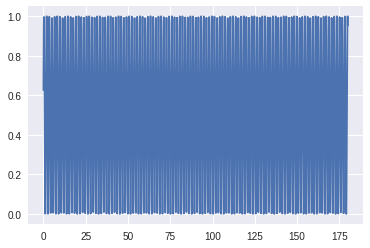

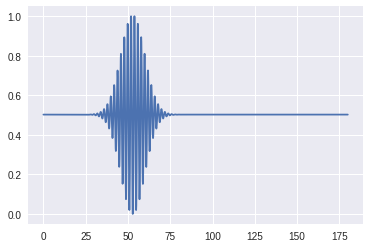

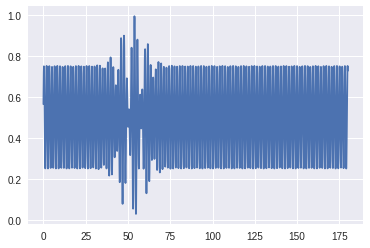

In [6]:
print(ts_s_train.shape)
print(ts_sg_train.shape)
print (ts_mix_train.shape)

# Time series examples

plt.plot(t, ts_s_train[0,:])
plt.show()
plt.plot(t, ts_sg_train[0,:])
plt.show()
plt.plot(t, ts_mix_train[0,:])
plt.show()

In [9]:
ts_mix_train.max()

1.0

## Validation

- 20 mixed signals + clean/target sources signals

### Time series

In [0]:
# Same as training 

ts_s_validation = np.zeros((200,N))
ts_sg_validation = np.zeros((200,N))

# noise
# noise = np.random.normal(loc=0.0, scale=10.0, size=1000)

for i in range(20):
    
    ts_s_validation[i,:] = a*np.sin(2*np.pi*t + phase_shift_sin[i]) #+ noise
    ts_sg_validation[i,:] = a*(np.exp(-(t-t0_sg[i])**2/tau**2))*(np.cos(2*np.pi*f0*(t-t0_sg[i])+phi0)) #+ noise
    
    ts_mix_validation = ts_s_validation + ts_sg_validation

## Testing

- 100 randomly generated useen mixed signals + clean/target sources for evaluation

### Time series

In [0]:
# Time series

ts_s_test = np.zeros((n,N))
ts_sg_test = np.zeros((n,N))

# noise
# noise = np.random.normal(loc=0.0, scale=10.0, size=1000)

for i in range(n):
    
    ts_s_test[i,:] = a*np.sin(2*np.pi*t + phase_shift_sin[i]) #+ noise
    ts_sg_test[i,:] = a*(np.exp(-(t-t0_sg[i])**2/tau**2))*(np.cos(2*np.pi*f0*(t-t0_sg[i])+phi0)) #+ noise
    
    ts_mix_test = ts_s_test + ts_sg_test

# Model

- Architecture is the same for each source. One net per source.
- Basically a convolutional AE with 1D input
- Loss function is the mean square error between the output and the clean target.
- Weights initiated randomly

### Time series

In [0]:
class CDAE(nn.Module):
    
    def __init__(self):
        super(CDAE, self).__init__()
        
        self.encoder = nn.Sequential(
            #input size: [batch_size, 1, 1800]
            nn.Conv1d(in_channels=1, out_channels=10, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Tanh(),
            # [batch_size, 10, 1800]
            nn.MaxPool1d(kernel_size=6, stride=6, padding=1),
            # [batch_size, 10, 300]
            nn.Conv1d(10, 20, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Tanh(),
            # [batch_size, 20, 300]
            nn.MaxPool1d(6, 6, padding=1),
            # [batch_size, 20, 50]
            nn.Conv1d(20, 30, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Tanh()
            # [batch_size, 30, 50]
            
        )
        
        self.decoder = nn.Sequential(
            # [batch_size, 30, 50]
            nn.ConvTranspose1d(30, 20, kernel_size=6, stride=6, bias=False),
            nn.Tanh(),
            # [batch_size, 20, 300]
            nn.ConvTranspose1d(20, 10, kernel_size=6, stride=6, bias=False),
            nn.Tanh(),
            # [batch_size, 10, 1800]
            nn.ConvTranspose1d(10, 1, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Tanh()
            # [batch_size, 1, 1800]
        )
        
    def forward(self, x):
        
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x  

In [0]:
#print(summary(CDAE, (N, 1, 1800)))

# Training

In [0]:
# Hyperparameters

num_epochs = 1000
batch_size = 50
lr = 0.001

torch.Size([1000, 1, 1800])
torch.Size([1000, 1, 1800])


<function matplotlib.pyplot.show>

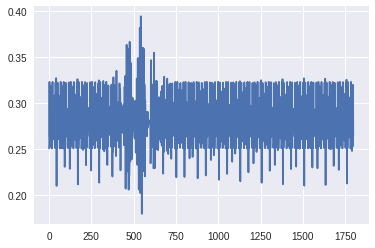

In [15]:
a = Variable(torch.from_numpy(ts_mix_train))
a = a.reshape(-1,1,N)
a = a.type(torch.FloatTensor)
m = nn.Conv1d(1, 1, kernel_size=3, stride=1, padding=1)
m1 = nn.MaxPool1d(6, stride=6, padding=1)
m2 = nn.ConvTranspose1d(1, 1, kernel_size=6, stride=6, padding=0)

b = m(a)
c = m1(b)
d = m2(c)

print(a.size())

print(d.size())

plt.plot(d[0, :, :].reshape(N).detach().cpu().numpy())
plt.show

epoch 0, loss 0.26197609305381775
None


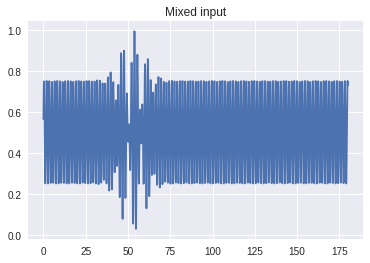

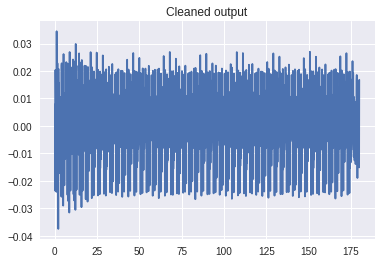

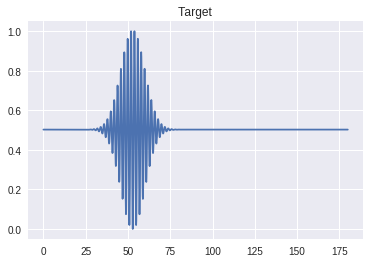

epoch 100, loss 0.009844010695815086
None


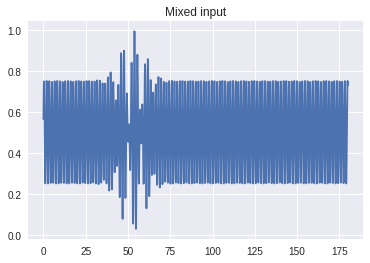

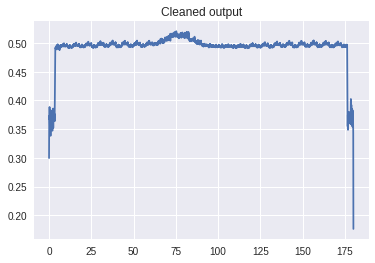

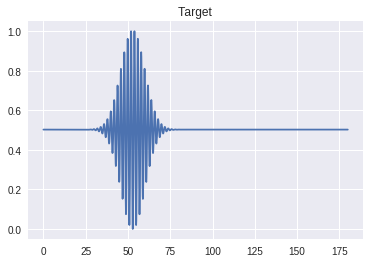

epoch 200, loss 0.009018657729029655
None


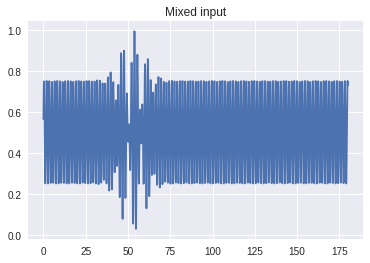

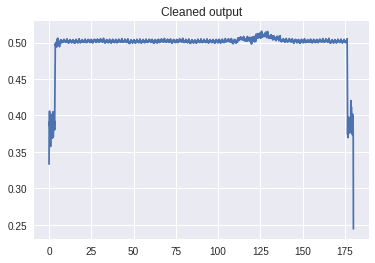

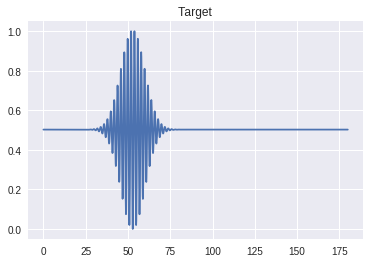

epoch 300, loss 0.009175979532301426
None


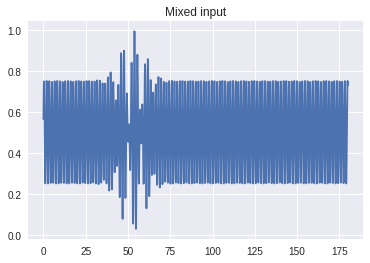

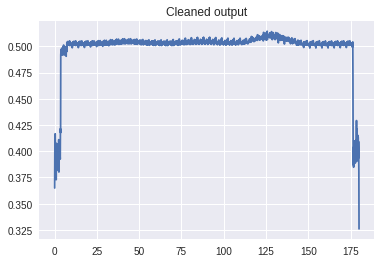

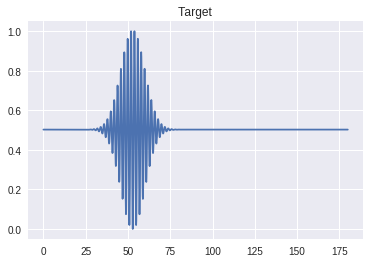

epoch 400, loss 0.009219580329954624
None


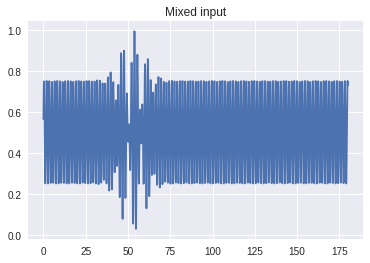

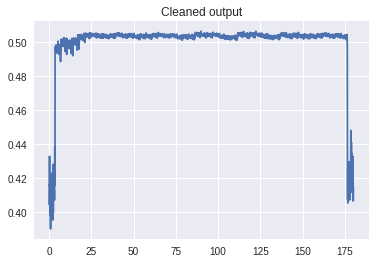

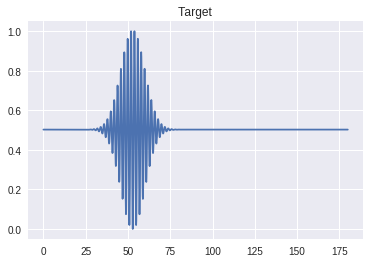

epoch 500, loss 0.008844926953315735
None


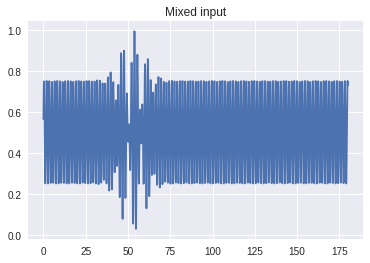

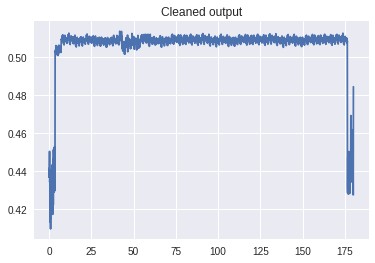

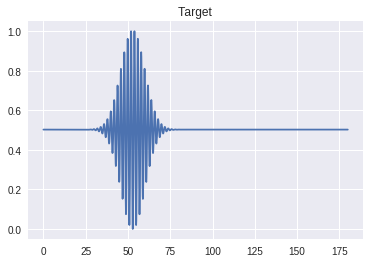

epoch 600, loss 0.008777255192399025
None


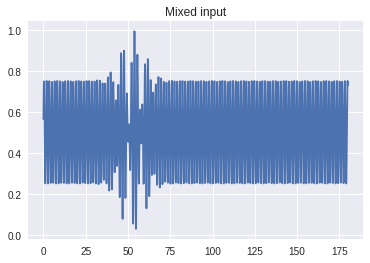

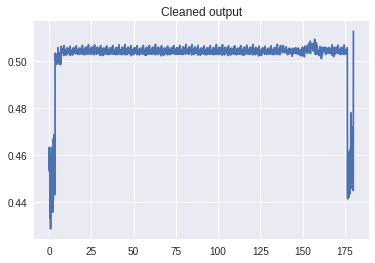

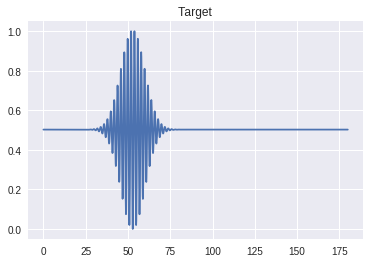

epoch 700, loss 0.008735350333154202
None


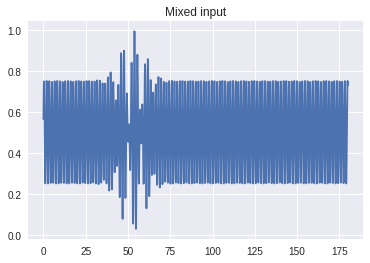

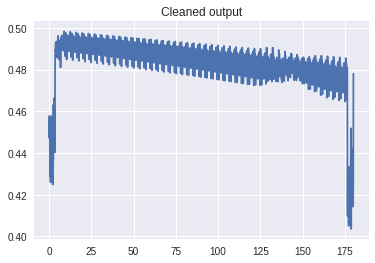

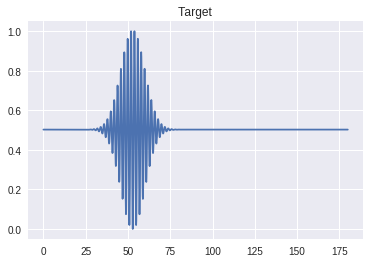

epoch 800, loss 0.008641802705824375
None


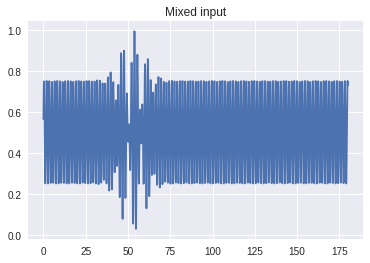

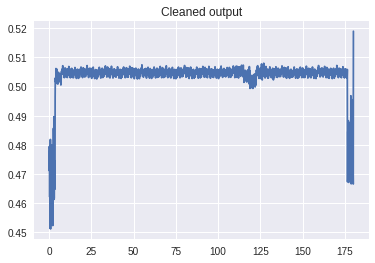

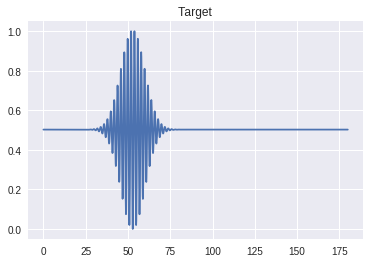

epoch 900, loss 0.0084881242364645
None


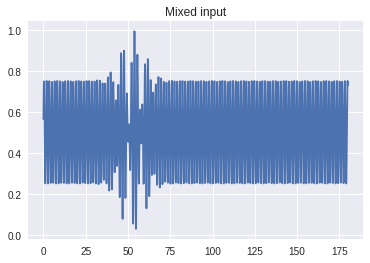

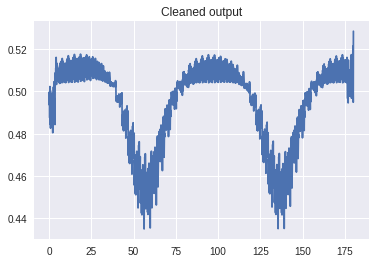

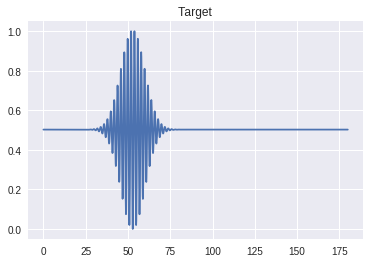

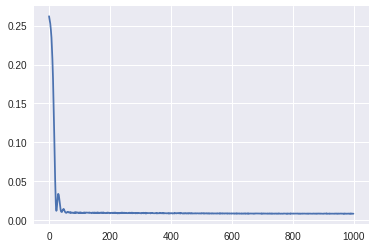

In [16]:
# This net will be trained to separate sine-gaussian waves from the mixed time series

inputs = Variable(torch.from_numpy(ts_mix_train)).to(device)
inputs = inputs.reshape(-1,1,N)
inputs = inputs.type(torch.cuda.FloatTensor)
#inputs = inputs.type(torch.FloatTensor)

sg_net = CDAE().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(sg_net.parameters(), lr=lr, weight_decay=1e-5)
loss_save = []
epoch = 0

for epoch in range(num_epochs):
    
    idx  = random.sample(list(np.arange(n)),batch_size) # 20 random indices on the 1000 ts 
    
    outputs = sg_net(inputs[idx,:,:])
    
    clean = Variable(torch.from_numpy(ts_sg_train)).to(device)
    clean = clean.reshape(-1,1,N)
    #clean = clean.type(torch.FloatTensor)
    clean = clean.type(torch.cuda.FloatTensor)
    
    
    loss = criterion(outputs, clean[idx,:,:])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_save.append(loss.item())
    
    # monitor progress
    if epoch%100==0:
        print(print('epoch {}, loss {}'.format(epoch, loss.item())))
        
        plt.plot(t, inputs[0,:,:].reshape(N).cpu().numpy())
        plt.title('Mixed input')
        plt.show()
        plt.plot(t, outputs[0,:,:].reshape(N).detach().cpu().numpy())
        plt.title('Cleaned output')
        plt.show()
        plt.plot(t, clean[0,:,:].reshape(N).cpu().numpy())
        plt.title('Target')
        plt.show()

plt.plot(loss_save)